# Local Mean Surface Temperature 
 
```{glue:figure} trend_fig
:scale: 50%
:align: right
```

Figure: Annual mean temperature anomalies relative to 1961–1990 climatology at Koror.  


## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os.path as op
import sys
import contextlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from myst_nb import glue 

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive, fig_int_to_glue
from ind_setup.plotting import plot_bar_probs, fontsize
from ind_setup.tables import get_data_metrics, plot_df_table

sys.path.append("../../../functions")
from data_downloaders import GHCN

from data_downloaders import GHCN, download_oni_index
from ind_setup.plotting_int import plot_oni_index_th
from ind_setup.plotting import plot_bar_probs_ONI, add_oni_cat
import df2img


### Define location and variables of interest

In [3]:
country = 'Palau'
vars_interest = ['TMIN', 'TMAX']

### Get Data

In [4]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

### Observations from Koror Station

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

The data used for this analysis comes from the GHCN (Global Historical Climatology Network)-Daily database. <br>
This a database that addresses the critical need for historical daily temperature, precipitation, and snow records over global land areas. GHCN-Daily is a
composite of climate records from numerous sources that were merged and then subjected to a suite of
quality assurance reviews. The archive includes over 40 meteorological elements including temperature daily maximum/minimum, temperature at observation time,
precipitation and more.

The next code blocks download the data and postprocess it to generate an easy to use dataframe with all the variables of interest for the analysis.

In [5]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

In [6]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_min = GHCN.extract_dict_data_var(GHCND_dir, 'TMIN', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    dict_max = GHCN.extract_dict_data_var(GHCND_dir, 'TMAX', df_country_stations.loc[df_country_stations['ID'] == id])[0][0]
    st_data = pd.concat([dict_min['data'], (dict_max['data'])], axis=1).dropna()
    st_data['diff'] = st_data['TMAX'] - st_data['TMIN']
    st_data['TMEAN'] = (st_data['TMAX'] + st_data['TMIN'])/2
    st_data.to_pickle(op.join(path_data, 'GHCN_surface_temperature.pkl'))
else:
    st_data = pd.read_pickle(op.join(path_data, 'GHCN_surface_temperature.pkl'))

In [7]:
st_data = st_data.resample('Y').mean()
glue("n_years", len(np.unique(st_data.index.year)), display=False)
glue("start_year", st_data.dropna().index[0].year, display=False)
glue("end_year", st_data.dropna().index[-1].year, display=False)

## Analysis

### Plotting

At this piece of code we will plot the Mean annual temperature over time and its associated trend

In [8]:
dict_plot = [{'data' : st_data, 'var' : 'TMEAN', 'ax' : 1, 'label' : 'TMEAN'},
        ]

In [9]:
dict_plot = [{'data' : st_data, 'var' : 'TMEAN', 'ax' : 1, 'label' : 'TMEAN'}]
fig = plot_timeseries_interactive(dict_plot, trendline=True, figsize = (25, 12))

glue("trend_fig_mean", fig_int_to_glue(fig), display=False)


**Fig.** Annual maxima corresponding to the mean temperature.

(26.0, 29.842663934426227)

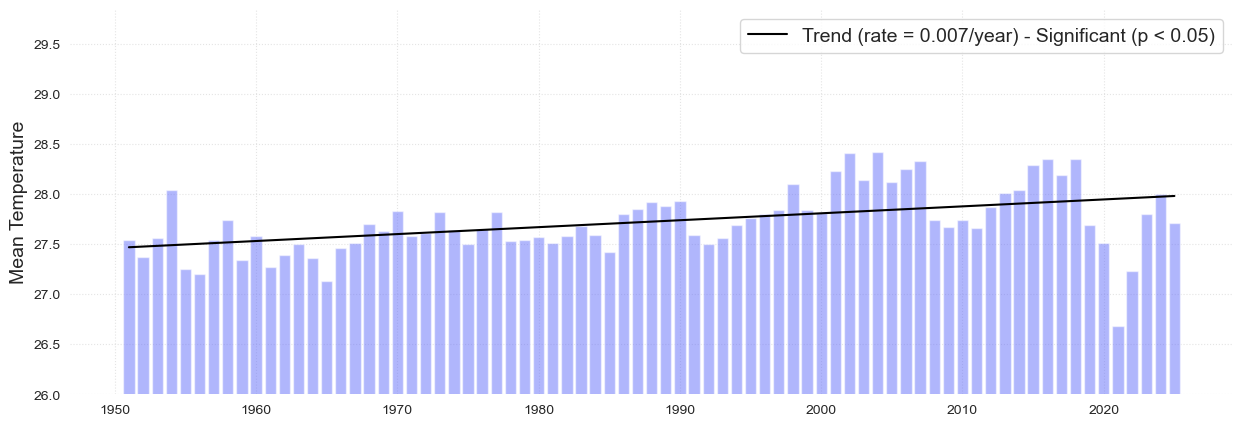

In [10]:
fig, ax, trend = plot_bar_probs(x = st_data.index.year, y = st_data['TMEAN'].values , trendline = True,
               figsize = (15, 5), y_label = f'Mean Temperature', return_trend = True)
ax.set_ylim(26, None)



Here we are creating a new column with the information of the temperature refered to the climatology of 1960 to 1990

In [11]:
mean_ref = st_data.loc['1961':'1990'].TMEAN.mean()
st_data['TMEAN_ref'] = st_data['TMEAN'] - mean_ref


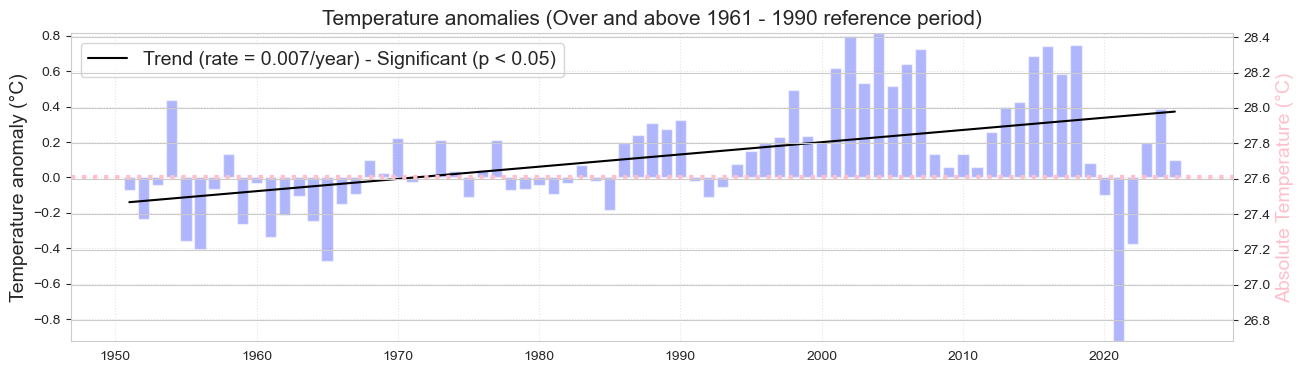

In [12]:
import matplotlib.pyplot as plt
fig, ax, trend = plot_bar_probs(x = st_data.index.year, y = st_data.TMEAN_ref, trendline = True, figsize = [15, 4], return_trend = True)
ax.set_ylim(st_data.TMEAN_ref.min(), st_data.TMEAN_ref.max())
ax2 = ax.twinx()
ax2.axhline(mean_ref, color='pink', linestyle=':', linewidth=3)
ax2.set_ylim(st_data.TMEAN_ref.min() + mean_ref, st_data.TMEAN_ref.max()+ mean_ref)
ax2.set_ylabel('Absolute Temperature (°C)', fontsize = fontsize, color = 'pink')
ax.set_ylabel('Temperature anomaly (°C)', fontsize = fontsize)
plt.title('Temperature anomalies (Over and above 1961 - 1990 reference period)', fontsize = 15);

### Table

In [13]:
nevents = 10
top_10 = st_data.sort_values(by='TMEAN_ref', ascending=False).head(nevents)

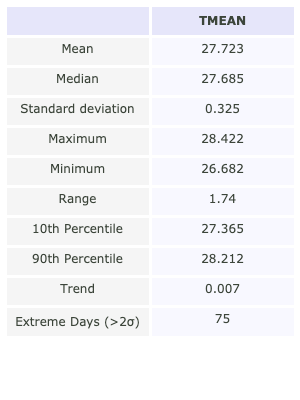

In [14]:
from ind_setup.tables import plot_df_table

var = 'TMEAN'
df = get_data_metrics(st_data, var, )
fig = plot_df_table(df.T, figsize = (300, 400))

The following bar plot represents the mean temperature anomalies with respect to the 1960-1990 climatology along with the 10 largest temperature events in the record

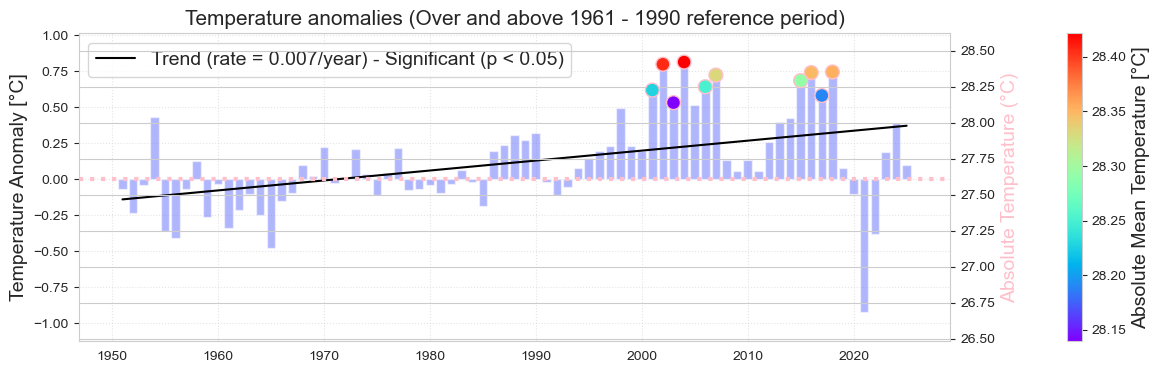

In [15]:
fig, ax, trend = plot_bar_probs(x=st_data.index.year, y=st_data.TMEAN_ref, trendline=True,
                                y_label='Temperature Anomaly [°C]', figsize=[15, 4], return_trend=True)


ax.set_ylim(st_data.TMEAN_ref.min()-.2, st_data.TMEAN_ref.max()+.2)
ax2 = ax.twinx()
ax2.axhline(mean_ref, color='pink', linestyle=':', linewidth=3)
ax2.set_ylim(st_data.TMEAN_ref.min()-.2 + mean_ref, st_data.TMEAN_ref.max() + .2 + mean_ref)
ax2.set_ylabel('Absolute Temperature (°C)', fontsize = fontsize, color = 'pink')

glue("trend_mean", float(trend), display=False)
glue("change_mean", float(trend * len(np.unique(st_data.index.year))), display=False)
glue("top_10_year", float(top_10.sort_index().index.year[0]), display=False)

im = ax2.scatter(top_10.index.year, top_10.TMEAN, 
                c=top_10.TMEAN.values, s=100, ec = 'pink', cmap='rainbow', label='Top 10 warmest years')
plt.title('Temperature anomalies (Over and above 1961 - 1990 reference period)', fontsize=15)
plt.colorbar(im, pad = .1).set_label('Absolute Mean Temperature [°C]', fontsize=fontsize)
glue("trend_fig", fig, display=False)


```{glue:figure} trend_fig
:name: "trend_fig_ST_10"

Annomaly of the mean temperature over and above the 1961-1990 reference period. Overlapping points correspond to the top 10 warmer years.

```

### El Niño Southern Oscillation Analysis

#### ONI index

The Oceanic Niño Index (ONI) is the standard measure used to monitor El Niño and La Niña events. It is based on sea surface temperature anomalies in the central equatorial Pacific (Niño 3.4 region) averaged over 3-month periods. 

https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

In [16]:

p_data = 'https://psl.noaa.gov/data/correlation/oni.data'

In [17]:
df1 = download_oni_index(p_data)

In [18]:
lims = [-.5, .5]
plot_oni_index_th(df1, lims = lims)

In [19]:
st_data_monthly = st_data.resample('M').mean()
st_data_monthly.index = pd.DatetimeIndex(st_data_monthly.index).to_period('M').to_timestamp() + pd.offsets.MonthBegin(1)

In [20]:
df1['tmin'] = st_data_monthly['TMIN']
df1['tmax'] = st_data_monthly['TMAX']
df1['tdiff'] = df1['tmax'] - df1['tmin']
df1['tmean'] = (df1['tmax'] + df1['tmin'])/2
df1['tmean_ref'] = df1['tmean'] - df1.loc['1961':'1990'].tmean.mean()
df1['tmean_ref_min'] = df1['tmean'] - df1.groupby(df1.index.year).max().tmean.min()
df1 = add_oni_cat(df1, lims = lims)

The following bar plot represents the mean temperature anomalies with respect to the 1960-1990 climatology. The color of the bar represents wether it is a El Niño or La Niña year.

In [21]:
df2 = df1.resample('Y').mean()
fig = plot_bar_probs_ONI(df2, var='tmean_ref');
fig.suptitle('Temperature Anomaly over the 1961-1990 mean', fontsize = fontsize)
plt.savefig(op.join(path_figs, 'F2_ST_Mean.png'), dpi=300, bbox_inches='tight')
plt.close()
# plt.show()

In [22]:
glue("fig_ninho", fig, display=False)

```{glue:figure} fig_ninho
:name: "fig_ninho"

Annual mean temperature anomalies relative to 1961–1990 climatology at Koror. The solid black line represents the trend, which is  statistically significant (p < 0.05).  Shading in the bar plots represent El Niño (red), La Niña (blue) and Neutral (grey) phases of ENSO as defined by values of the Oceanic Niño Index (ONI). 

```

In [23]:
df_format = np.round(df1.describe(), 2)

## Generate table
Table sumarizing different metrics of the data analyzed in the plots above

In [24]:
from ind_setup.tables import style_matrix, table_temp_11

In [25]:
style_matrix(table_temp_11(df1, trend))

Metric,Value
Mean Temperature,27.724
Change in Annual Mean Temperature since 1960,0.455
Rate of Change (°C/year),0.007
